In [47]:
%matplotlib inline
import os
seed = 50
os.environ['PYTHONHASHSEED']=str(seed)
import scipy.io
import seaborn as sns
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from sklearn.model_selection import KFold
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import clear_output, display
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.cross_decomposition import PLSRegression 
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
from tensorly.decomposition import robust_pca
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
# from tensorly.regression.cp_regression import CPRegressor
from tensorly.regression.tucker_regression import TuckerRegressor
from hopls import matricize, qsquared, HOPLS
import random
from qpfs import *
from Autoencoder import *
from utils import *
from hankelization import * 
random_seed = 5
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
!CUBLAS_WORKSPACE_CONFIG=:16:8#:4096:8
device='cuda:0'
# device='cpu'

In [48]:
X_full = scipy.io.loadmat('X_EEG60.mat')['features1']
Y_full = scipy.io.loadmat('Y_EEG60.mat')['motion_dim1']
print('X:',X_full.shape[0])
print('Y:',Y_full.shape[0])

X: 18901
Y: 18901


# Human EEG dataset, 60 channels

The dataset includes $60$-channel electroencephalography (EEG), $7$-channel electromyography (EMG), and $4$-channel electrooculography (EOG) of healthy subjects. Subjects performed different upper-extremity movement tasks. The original EEG signals are converted into a space time representation using a wavelet transform with Morlet wavelet. So, $X \in \mathbb{R}^{T \times 64 \times 24}$, where $24$ - number of frequencies. $Y \in \mathbb{R}^{T \times 3}$ - coordinates of hand position.

<img src="pictures/2023-04-14_22-44-26.png" alt="Drawing" style="width: 400px;"/>

<img src="pictures/2023-04-14_22-45-20.png" alt="Drawing" style="width: 200px;"/>

In [49]:
X_train_arr_n = []
X_test_arr_n = []
Y_train_arr_n = []
Y_test_arr_n = []
for j in range(10):
    X_test = np.transpose(X_full, (0,2,1))[(j*200)+2500:(j*200)+4250]
    Y_test = Y_full[(j*200)+2500:(j*200)+4250]
    X_train = np.transpose(X_full, (0,2,1))[(j*200):(j*200)+2500]
    Y_train = Y_full[(j*200):(j*200)+2500]

    X_test = (X_test - X_test.mean()) / X_test.std() 
    Y_test = (Y_test - Y_test.mean()) / Y_test.std()
    X_train = (X_train - X_train.mean()) / X_train.std()
    Y_train = (Y_train - Y_train.mean()) / Y_train.std()
    X_test_arr_n.append(X_test)
    Y_test_arr_n.append(Y_test)
    X_train_arr_n.append(X_train)
    Y_train_arr_n.append(Y_train)
    
X_train_arr_t = []
X_test_arr_t = []
Y_train_arr_t = []
Y_test_arr_t = []
for j in range(10):
    X_test_arr_t.append(torch.from_numpy(X_test_arr_n[j]).float().to(device))
    Y_test_arr_t.append(torch.from_numpy(Y_test_arr_n[j]).float().to(device))
    X_train_arr_t.append(torch.from_numpy(X_train_arr_n[j]).float().to(device))                    
    Y_train_arr_t.append(torch.from_numpy(Y_train_arr_n[j]).float().to(device))                                       

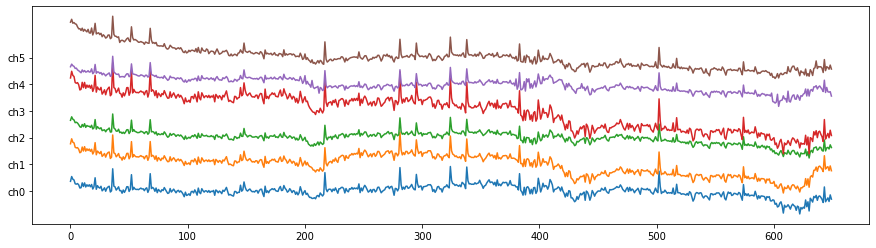

In [6]:
plot_y(Y_train_arr_n[0], 750)
# till=750
# fig = plt.figure(figsize=(17,5))
# if till<1000:
#     maximum = Y.std() 
# else:
#     maximum = Y.mean() 
# for i in range(Y.shape[1]):
#     plt.plot(Y[200:till+200,i] - Y[200:till+200,i].mean() + maximum*i)
# plt.yticks(ticks=[maximum*i  for i in range(Y.shape[1])], labels=[f'ch{i}' for i in range(Y.shape[1])])
# plt.xlabel('Time')
# plt.savefig('EMG_eeg.jpg')

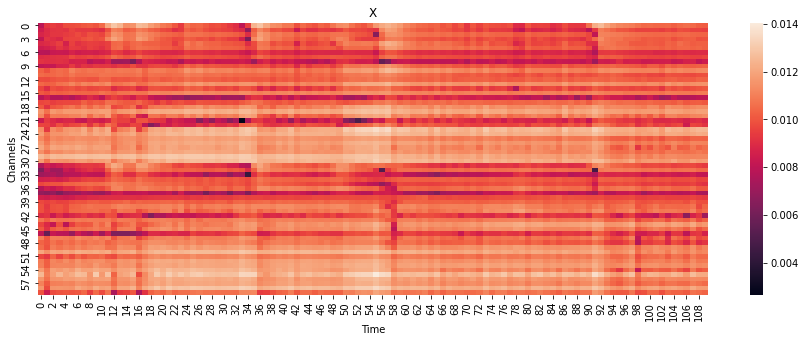

In [7]:
plot_x(X_train_arr_n[0])

In [8]:
# f, ax = plt.subplots(figsize=(15, 5))
# ax = sns.heatmap(X_test_n[50:160,1,:].T)
# ax.set_xlabel('Time')
# ax.set_ylabel('Channels')
# plt.savefig('EEG_eeg.jpg')
# plt.show()

## Without hankelization
### HOPLS

In [5]:
MSE_test = {}
for ks1 in tqdm(range(1,4)):
    for ks2 in range(1,9):
        for ks3 in range(1,6):
            Ln = [ks1,ks2]
            Km = [ks3]
            rmse_test, rmse_train, R = compute_rmse_hopls(X_train_arr_n[0], Y_train_arr_n[0], X_test_arr_n[0], Y_test_arr_n[0], Ln, Km, R_max=20)
            MSE_test[f'Ln = ({ks1},{ks2}), Km = {ks3}, R = {R}'] = rmse_test

print('Test. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

100%|██████████| 3/3 [14:34<00:00, 291.40s/it]

Test. Size of core tensor is Ln = (1,8), Km = 1, R = 19 nRMSE = 1.3009797386075872


100%|██████████| 30/30 [22:16<00:00, 44.55s/it]


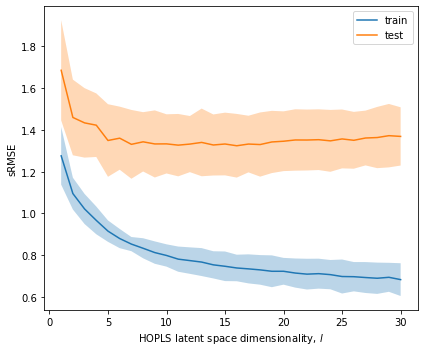

16 components with nRMSE = 1.3242941340277283 +- 0.13116642276463295


In [9]:
rmse = []
for R in tqdm(range(1,31)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_train_arr_n[j],Y_train_arr_n[j],X_test_arr_n[j],Y_test_arr_n[j], [1,8], [1], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [24]:
U_x = scipy.io.loadmat('MPCA/60_X.mat')['ans']
print([U_x[i,0].shape[0] for i in range(U_x.shape[0])])

[1, 10]


In [11]:
MSE_test = dict(np.load('experiments/EEG60_wt_wt_mpca.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is (1, 7) nRMSE = 1.7729764183174608


In [25]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_train_arr_n[j],Y_train_arr_n[j],X_test_arr_n[j],Y_test_arr_n[j], [1,7], U_x))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [22:09<00:00, 132.95s/it]

1.7660971348734988 +- 0.18959861640464817


### Autoencoder

In [6]:
MSE_test = dict(np.load('experiments/EEG60_wt.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 12,8


In [50]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 50
step_size = 100

RMSE_AE = []
for j in tqdm(range(10)):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks = [fr,32,16,12]
    model = AutoEncoder_tensor(3, [ks], [ch,8], y_sh, indexing=False).to(device)
    model = train(model, X_train_arr_t[j], Y_train_arr_t[j], X_test_arr_t[j], Y_test_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, False);

    X_train_lower = model.encode(X_train_arr_t[j]).cpu().detach().numpy()
    X_test_lower = model.encode(X_test_arr_t[j]).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,2):   
        for rank2 in range(1,X_train_lower.shape[2]+1,2):
            try:
                RMSE_dict[f'{rank1},{rank2}'] = tensor_regression(X_train_lower, Y_train_arr_n[j], X_test_lower, Y_test_arr_n[j], [rank1,rank2])
            except:
                continue
    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

100%|██████████| 10/10 [1:05:36<00:00, 393.61s/it]


In [51]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std())

1.3528581662348214 +- 0.1513307253309109


In [52]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks = [fr,32,16,12]
model = AutoEncoder_tensor(3, [ks], [ch,8], y_sh, indexing=False).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 22962


## With hankelization along time dim

In [10]:
X_tr_ht_arr_n = []
X_te_ht_arr_n = []
Y_tr_ht_arr_n = []
Y_te_ht_arr_n = []
H_t_arr = []
for j in tqdm(range(10)):
    data, H_t = tensorization(X_train_arr_n[j], Y_train_arr_n[j], X_test_arr_n[j], Y_test_arr_n[j], [[10],[10]], [[0],[0]])
    X_tr_ht_n, Y_tr_ht_n, X_te_ht_n, Y_te_ht_n = data
    X_tr_ht_arr_n.append(X_tr_ht_n)
    Y_tr_ht_arr_n.append(Y_tr_ht_n)
    X_te_ht_arr_n.append(X_te_ht_n)
    Y_te_ht_arr_n.append(Y_te_ht_n)
    H_t_arr.append(H_t)
    
X_tr_ht_arr_t = []
X_te_ht_arr_t = []
Y_tr_ht_arr_t = []
Y_te_ht_arr_t = []
for j in range(10):
    X_tr_ht_arr_t.append(torch.from_numpy(X_tr_ht_arr_n[j]).float().to(device))
    X_te_ht_arr_t.append(torch.from_numpy(X_te_ht_arr_n[j]).float().to(device))
    Y_tr_ht_arr_t.append(torch.from_numpy(Y_tr_ht_arr_n[j]).float().to(device))                    
    Y_te_ht_arr_t.append(torch.from_numpy(Y_te_ht_arr_n[j]).float().to(device))  

print('X train:', X_tr_ht_arr_n[0].shape)
print('Y train:', Y_tr_ht_arr_n[0].shape)
print('X test:', X_te_ht_arr_n[0].shape)
print('Y test:', Y_te_ht_arr_n[0].shape)

100%|██████████| 10/10 [06:03<00:00, 36.39s/it]


X train: (2491, 10, 24, 60)
Y train: (2491, 10, 6)
X test: (1741, 10, 24, 60)
Y test: (1741, 10, 6)


### HOPLS

In [4]:
MSE_test = {}
for ks1 in range(1,4):
    for ks2 in tqdm(range(1,5)):
        for ks3 in range(1,8):
            for ks4 in range(1,3):
                for ks5 in range(1,3):
                    Ln = [ks1,ks2,ks3]
                    Km = [ks4,ks5]
                    rmse_test, rmse_train, R = compute_rmse_hopls(X_tr_ht_n, Y_tr_ht_n, X_te_ht_n, Y_te_ht_n, Ln, Km, R_max=15, hankelization=[H_t[-2],H_t[-1]])
                    MSE_test[f'Ln = ({ks1},{ks2},{ks3}), Km = ({ks4},{ks5}), R = {R}'] = rmse_test

print('Test. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

100%|██████████| 4/4 [12:40:29<00:00, 11407.35s/it]

Test. Size of core tensor is Ln = (3,2,7), Km = (2,1), R = 7 nRMSE = 1.6845740793280877


100%|██████████| 30/30 [3:05:34<00:00, 371.15s/it]  


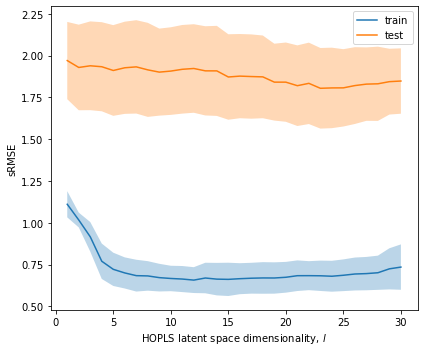

23 components with nRMSE = 1.8046483911634053 +- 0.19550183885887581


In [41]:
rmse = []
for R in tqdm(range(1,31)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_tr_ht_arr_n[j],Y_tr_ht_arr_n[j],X_te_ht_arr_n[j],Y_te_ht_arr_n[j], [3,2,7], [2,1], hankelization=[H_t_arr[j][-2],H_t_arr[j][-1]], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [27]:
U_x = scipy.io.loadmat('MPCA/60_X_ht.mat')['ans']
U_y = scipy.io.loadmat('MPCA/60_Y_ht.mat')['ans']
print('X',[U_x[i,0].shape[0] for i in range(U_x.shape[0])])
print('Y',[U_y[i,0].shape[0] for i in range(U_y.shape[0])])

X [9, 1, 11]
Y [9, 4]


In [19]:
MSE_test = dict(np.load('experiments/EEG60_ht_ht_mpca.npz'))
print('Time. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Time. Size of core tensor is (5, 1, 1) nRMSE = 2.486522327473318


In [28]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_tr_ht_arr_n[j],Y_tr_ht_arr_n[j],X_te_ht_arr_n[j],Y_te_ht_arr_n[j], [5,1,1], U_x, U_y, H_t_arr[j][-1]))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [22:32<00:00, 135.24s/it]

2.498793646422296 +- 0.353479624820136


### Autoencoder

In [5]:
MSE_test = dict(np.load('experiments/EEG60_ht.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 4,1,3


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 20
step_size = 100

RMSE_AE = []
for j in range(10):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks1 = [fr,32,16,8,1]
    ks2 = [ch,16,8,3]

    model = AutoEncoder_tensor(4, [ks1, ks2], [10,4], y_sh*10, indexing=True).to(device)
    model = train(model, X_tr_ht_arr_t[j],Y_tr_ht_arr_t[j],X_te_ht_arr_t[j],Y_te_ht_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, False);

    X_train_lower = model.encode(X_tr_ht_arr_t[j]).cpu().detach().numpy()
    X_test_lower = model.encode(X_te_ht_arr_t[j]).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,1):   
        for rank2 in range(1,X_train_lower.shape[2]+1,1):
            for rank3 in range(1,X_train_lower.shape[3]+1,1):
                    RMSE_dict[f'{rank1},{rank2},{rank3}'] = tensor_regression(X_train_lower, Y_tr_ht_arr_n[j], X_test_lower, Y_te_ht_arr_n[j], [rank1,rank2,rank3], H_t_arr[j][-1])

    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

In [12]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std())

1.6355635638935824 +- 0.21001704135495897


In [53]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks1 = [fr,32,16,8,1]
ks2 = [ch,16,8,3]

model = AutoEncoder_tensor(4, [ks1, ks2], [10,4], y_sh*10, indexing=True).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 7476


## With hankelization along space dim

In [7]:
X_tr_hs_arr_n = []
X_te_hs_arr_n = []
Y_tr_hs_arr_n = []
Y_te_hs_arr_n = []
for j in tqdm(range(10)):
    data, H_s = tensorization(X_train_arr_n[j], Y_train_arr_n[j], X_test_arr_n[j], Y_test_arr_n[j], [[2],[]], [[2],[]])
    X_tr_hs_n, Y_tr_hs_n, X_te_hs_n, Y_te_hs_n = data
    X_tr_hs_arr_n.append(X_tr_hs_n)
    Y_tr_hs_arr_n.append(Y_tr_hs_n)
    X_te_hs_arr_n.append(X_te_hs_n)
    Y_te_hs_arr_n.append(Y_te_hs_n)
    
X_tr_hs_arr_t = []
X_te_hs_arr_t = []
Y_tr_hs_arr_t = []
Y_te_hs_arr_t = []
for j in range(10):
    X_tr_hs_arr_t.append(torch.from_numpy(X_tr_hs_arr_n[j]).float().to(device))
    X_te_hs_arr_t.append(torch.from_numpy(X_te_hs_arr_n[j]).float().to(device))
    Y_tr_hs_arr_t.append(torch.from_numpy(Y_tr_hs_arr_n[j]).float().to(device))                    
    Y_te_hs_arr_t.append(torch.from_numpy(Y_te_hs_arr_n[j]).float().to(device))  

print('X train:', X_tr_hs_arr_n[0].shape)
print('Y train:', Y_tr_hs_arr_n[0].shape)
print('X test:', X_te_hs_arr_n[0].shape)
print('Y test:', Y_te_hs_arr_n[0].shape)

100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


X train: (2500, 24, 59, 2)
Y train: (2500, 6)
X test: (1750, 24, 59, 2)
Y test: (1750, 6)


### HOPLS

In [5]:
MSE_test = dict(np.load('experiments/EEG60_hs_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (3,1,2), Km = (1), R = 12 nRMSE = 1.3349915634431622


100%|██████████| 20/20 [22:23<00:00, 67.15s/it] 


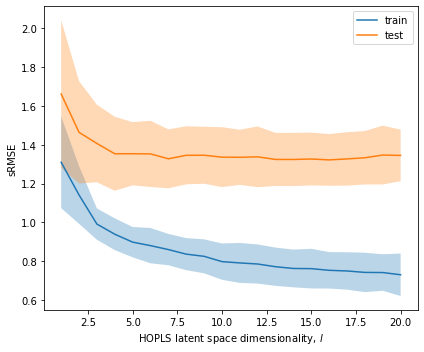

16 components with nRMSE = 1.3217865223853795 +- 0.13319716909255083


In [42]:
rmse = []
for R in tqdm(range(1,21)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_tr_hs_arr_n[j],Y_tr_hs_arr_n[j],X_te_hs_arr_n[j],Y_te_hs_arr_n[j], [3,1,2], [1], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [31]:
U_x = scipy.io.loadmat('MPCA/60_X_hs.mat')['ans']
print([U_x[i,0].shape[0] for i in range(U_x.shape[0])])

[1, 14, 2]


In [21]:
MSE_test = dict(np.load('experiments/EEG60_hs_hs_mpca.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is (1, 9, 2) nRMSE = 1.5629881245237132


In [32]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_tr_hs_arr_n[j],Y_tr_hs_arr_n[j],X_te_hs_arr_n[j],Y_te_hs_arr_n[j], [1,9,2], U_x))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [13:40<00:00, 82.00s/it]

1.6987802226468858 +- 0.22219387707037833


### Autoencoder

In [4]:
MSE_test = dict(np.load('experiments/EEG60_hs.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 4,1,1


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 60
step_size = 100
X_tr_hs_n, X_te_hs_n = X_tr_hs_n.transpose(0,2,1,3), X_te_hs_n.transpose(0,2,1,3)

RMSE_AE = []
for j in range(10):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks1 = [fr,32,16,8,4]

    model = AutoEncoder_tensor(4, [ks1, [2,3,1]], [ch-1,1], y_sh, indexing=True).to(device)
    model = train(model, X_tr_hs_arr_t[j].permute((0,2,1,3)),Y_tr_hs_arr_t[j],X_te_hs_arr_t[j].permute((0,2,1,3)),Y_te_hs_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, False);

    X_train_lower = model.encode(X_tr_hs_arr_t[j].permute((0,2,1,3))).cpu().detach().numpy()
    X_test_lower = model.encode(X_te_hs_arr_t[j].permute((0,2,1,3))).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,1):   
        for rank2 in range(1,X_train_lower.shape[2]+1,1):
            for rank3 in range(1,X_train_lower.shape[3]+1,1):
                    RMSE_dict[f'{rank1},{rank2},{rank3}'] = tensor_regression(X_train_lower, Y_tr_hs_arr_n[j], X_test_lower, Y_te_hs_arr_n[j], [rank1,rank2,rank3])

    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

In [ ]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std())

1.338489108851609 +- 0.1047231812790777


In [54]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks1 = [fr,32,16,8,4]

model = AutoEncoder_tensor(4, [ks1, [2,3,1]], [ch-1,1], y_sh, indexing=True).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 18255


## With hankelization along both dim

In [10]:
X_tr_hb_arr_n = []
X_te_hb_arr_n = []
Y_tr_hb_arr_n = []
Y_te_hb_arr_n = []
H_b_arr = []
for j in tqdm(range(10)):
    data, H_b = tensorization(X_train_arr_n[j], Y_train_arr_n[j], X_test_arr_n[j], Y_test_arr_n[j], [[10,2],[10]], [[0,2],[0]])
    X_tr_hb_n, Y_tr_hb_n, X_te_hb_n, Y_te_hb_n = data
    X_tr_hb_arr_n.append(X_tr_hb_n)
    Y_tr_hb_arr_n.append(Y_tr_hb_n)
    X_te_hb_arr_n.append(X_te_hb_n)
    Y_te_hb_arr_n.append(Y_te_hb_n)
    H_b_arr.append(H_b)
    
X_tr_hb_arr_t = []
X_te_hb_arr_t = []
Y_tr_hb_arr_t = []
Y_te_hb_arr_t = []
for j in range(10):
    X_tr_hb_arr_t.append(torch.from_numpy(X_tr_hb_arr_n[j]).float().to(device))
    X_te_hb_arr_t.append(torch.from_numpy(X_te_hb_arr_n[j]).float().to(device))
    Y_tr_hb_arr_t.append(torch.from_numpy(Y_tr_hb_arr_n[j]).float().to(device))                    
    Y_te_hb_arr_t.append(torch.from_numpy(Y_te_hb_arr_n[j]).float().to(device))  

print('X train:', X_tr_hb_arr_n[0].shape)
print('Y train:', Y_tr_hb_arr_n[0].shape)
print('X test:', X_te_hb_arr_n[0].shape)
print('Y test:', Y_te_hb_arr_n[0].shape)

100%|██████████| 10/10 [14:02<00:00, 84.26s/it]


X train: (2491, 10, 24, 59, 2)
Y train: (2491, 10, 6)
X test: (1741, 10, 24, 59, 2)
Y test: (1741, 10, 6)


### HOPLS

In [12]:
MSE_test = dict(np.load('experiments/EEG60_hb_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (2,2,5,2), Km = (1,4), R = 15 nRMSE = 1.6989911445416375


100%|██████████| 20/20 [2:55:11<00:00, 525.57s/it]  


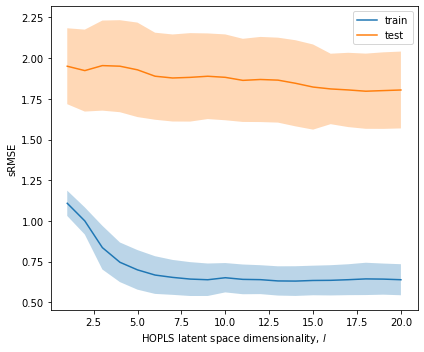

18 components with nRMSE = 1.796961388796379 +- 0.21641253936108198


In [43]:
rmse = []
for R in tqdm(range(1,21)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_tr_hb_arr_n[j],Y_tr_hb_arr_n[j],X_te_hb_arr_n[j],Y_te_hb_arr_n[j], (2,2,5,2), (1,4), hankelization=[H_b_arr[j][-2],H_b_arr[j][-1]], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [35]:
U_x = scipy.io.loadmat('MPCA/60_X_hb.mat')['ans']
U_y = scipy.io.loadmat('MPCA/60_Y_hb.mat')['ans']
print('X',[U_x[i,0].shape[0] for i in range(U_x.shape[0])])
print('Y',[U_y[i,0].shape[0] for i in range(U_y.shape[0])])

X [9, 1, 14, 2]
Y [9, 4]


In [23]:
MSE_test = dict(np.load('experiments/EEG60_hb_hb_mpca.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is (1, 1, 5, 2) nRMSE = 2.3351878696960786


In [36]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_tr_hb_arr_n[j],Y_tr_hb_arr_n[j],X_te_hb_arr_n[j],Y_te_hb_arr_n[j], [1,1,5,2], U_x, U_y, H_b_arr[j][-1]))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [47:28<00:00, 284.87s/it]

2.635051403025481 +- 0.4984769385577134


### Autoencoder

In [3]:
MSE_test = dict(np.load('experiments/EEG60_hb.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 3,1,4,2


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 35
step_size = 100

RMSE_AE = []
for j in range(10):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks1 = [fr,32,16,8,1]
    ks2 = [ch-1,16,8,4]

    model = AutoEncoder_tensor(5, [ks1, ks2, [2,3,2]], [10,3], y_sh*10, indexing=True).to(device)
    model = train(model, X_tr_hb_arr_t[j],Y_tr_hb_arr_t[j],X_te_hb_arr_t[j],Y_te_hb_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, True);

    X_train_lower = model.encode(X_tr_hb_arr_t[j]).cpu().detach().numpy()
    X_test_lower = model.encode(X_te_hb_arr_t[j]).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,1):   
        for rank2 in range(1,X_train_lower.shape[2]+1,1):
            for rank3 in range(1,X_train_lower.shape[3]+1,1):
                for rank4 in range(1,X_train_lower.shape[4]+1,1):
                    RMSE_dict[f'{rank1},{rank2},{rank3},{rank4}'] = tensor_regression(X_train_lower, Y_tr_hb_arr_n[j], X_test_lower, Y_te_hb_arr_n[j], [rank1,rank2,rank3,rank4], H_b_arr[j][-1])

    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

In [ ]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std())

1.4760768676297071 +- 0.2603856725792859


In [55]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks1 = [fr,32,16,8,1]
ks2 = [ch-1,16,8,4]

model = AutoEncoder_tensor(5, [ks1, ks2, [2,3,2]], [10,3], y_sh*10, indexing=True).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 8118


In [38]:
Y_random = []
Y_zeros = []
for j in range(10):
    Y_zeros.append(np.zeros(Y_test_arr_n[j].shape))
    Y_random.append(np.random.normal(0,1,Y_test_arr_n[j].shape))

In [39]:
rmse_random = []
rmse_zeros = []
for j in range(10):
    rmse_random.append(metric_nmse_(Y_random[j],Y_test_arr_n[j]))
    rmse_zeros.append(metric_nmse_(Y_zeros[j],Y_test_arr_n[j]))

In [40]:
print(np.array(rmse_zeros).mean(), '+-', np.array(rmse_zeros).std())
print(np.array(rmse_random).mean(), '+-', np.array(rmse_random).std())

2.2421311079370803 +- 0.2419148222876418
3.800340935697185 +- 0.4996068724438889


In [39]:
plt.rcParams.update({
    # Use LaTeX default serif font-family.
    # https://matplotlib.org/stable/tutorials/text/usetex.html#sphx-glr-tutorials-text-usetex-py
     "font.family": "serif",
     # Use specific cursive fonts.
     "font.cursive": ["Comic Neue", "Comic Sans MS"],
 })
plt.style.use('seaborn-white')

plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.titlesize'] = 20

%matplotlib inline
%config InlineBackend.figure_format='retina'

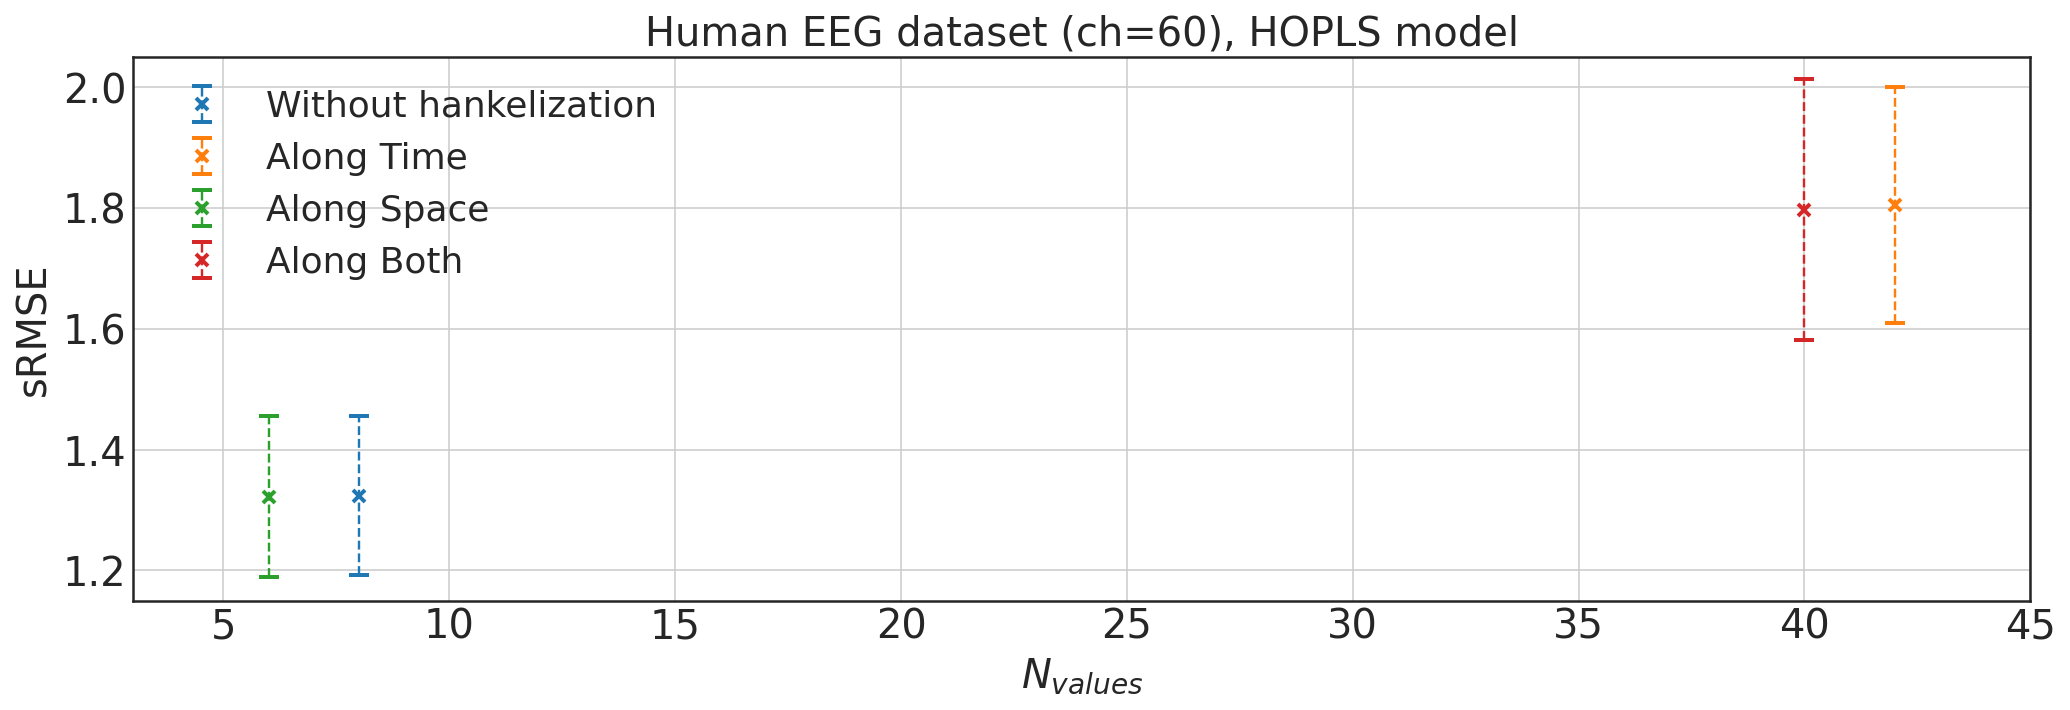

In [44]:
fig = plt.figure(figsize=(17,5))
labels = ['Without hankelization', 'Along Time', 'Along Space', 'Along Both']
xs = np.array([8, 42, 6, 40])
ys = np.array([1.324, 1.805, 1.322, 1.797])
es = np.array([0.131, 0.196, 0.133, 0.216])

for x, y, e, c in zip(xs,ys,es,range(4)):
    eb1=plt.errorbar(x, y, e, linestyle='None', marker='x', capsize=5, elinewidth=1.2, markeredgewidth=2, label=labels[c])#, ecolor=c)
    eb1[-1][0].set_linestyle('--') 
# for i,(xitem,yitem) in enumerate(np.nditer([xs,ys])):
#     plt.annotate(labels[i], (xitem,yitem), textcoords="offset points",xytext=((-1)**(i)*35,(-1)**(i//2)*10),ha="center")
plt.ylim(1.15,2.05)
plt.xlim(3,45)
plt.ylabel('sRMSE', fontsize=20)
plt.xlabel(r'$N_{values}$', fontsize=20)
plt.grid(True)
plt.legend()
plt.savefig('EEG60_HOPLS.jpg', dpi=300)
plt.title('Human EEG dataset (ch=60), HOPLS model')
plt.show()

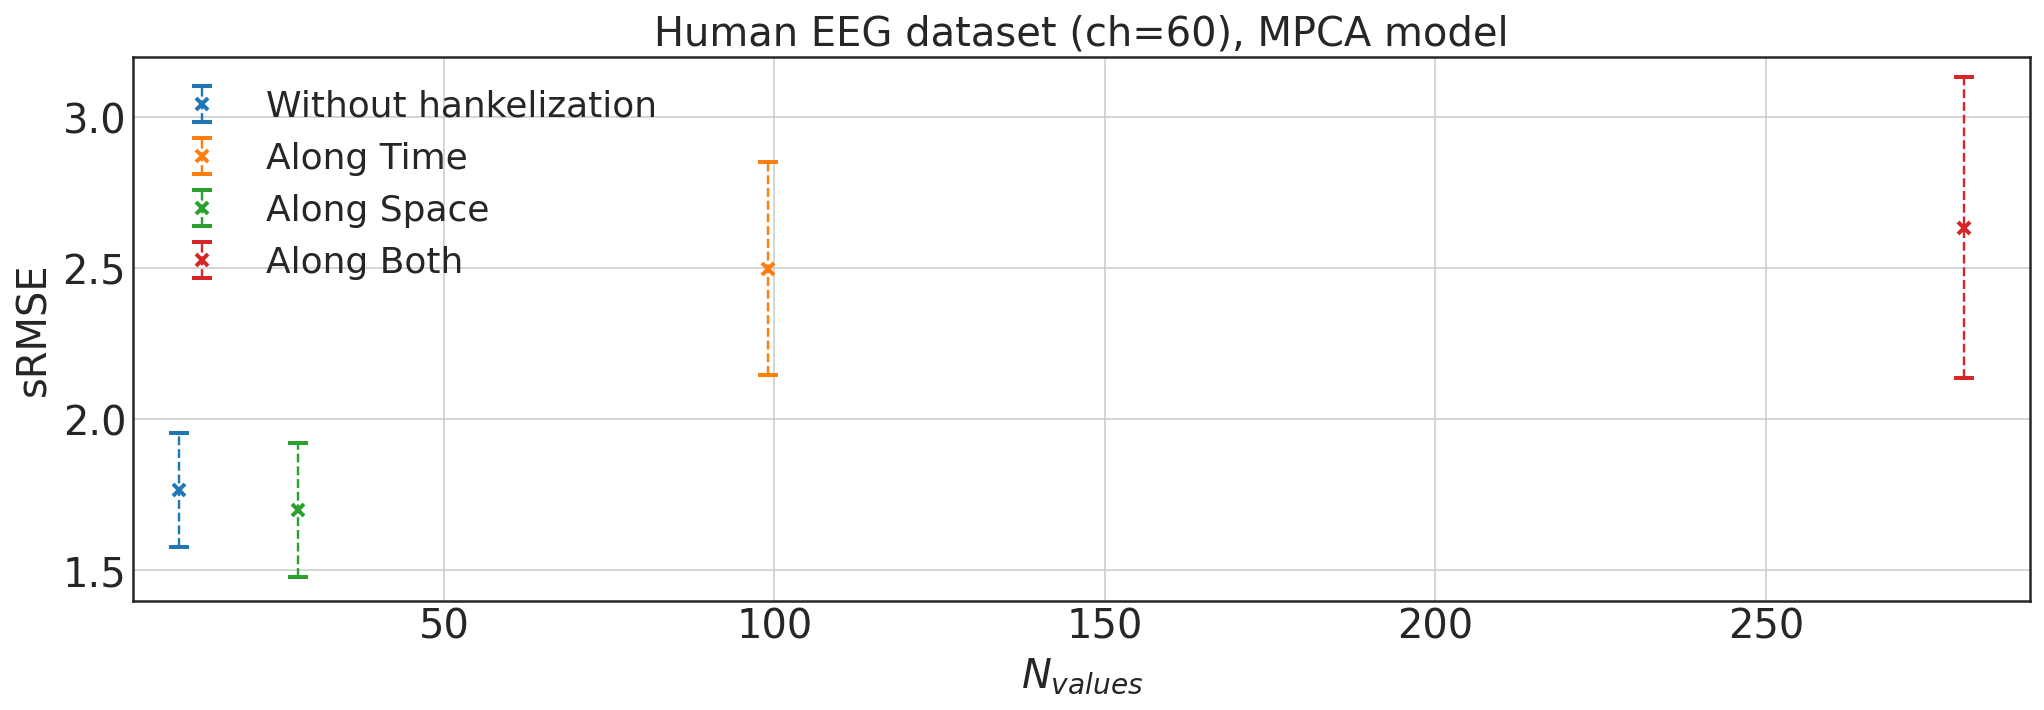

In [45]:
fig = plt.figure(figsize=(17,5))
labels = ['Without hankelization', 'Along Time', 'Along Space', 'Along Both']
xs = np.array([10, 99, 28, 280])
ys = np.array([1.766, 2.499, 1.699, 2.635])
es = np.array([0.190, 0.353, 0.222, 0.498])

for x, y, e, c in zip(xs,ys,es,range(4)):
    eb1=plt.errorbar(x, y, e, linestyle='None', marker='x', capsize=5, elinewidth=1.2, markeredgewidth=2, label=labels[c])#, ecolor=c)
    eb1[-1][0].set_linestyle('--') 
# for i,(xitem,yitem) in enumerate(np.nditer([x,y])):
#     plt.annotate(labels[i], (xitem,yitem), textcoords="offset points",xytext=((-1)**(i)*35,(-1)**(i//2)*10),ha="center", fontsize=15)
plt.ylim(1.4,3.2)
plt.xlim(3,290)
plt.ylabel('sRMSE', fontsize=20)
plt.xlabel(r'$N_{values}$', fontsize=20)
plt.grid(True)
plt.legend()
plt.savefig('EEG60_MPCA.jpg', dpi=300)
plt.title('Human EEG dataset (ch=60), MPCA model')
plt.show()

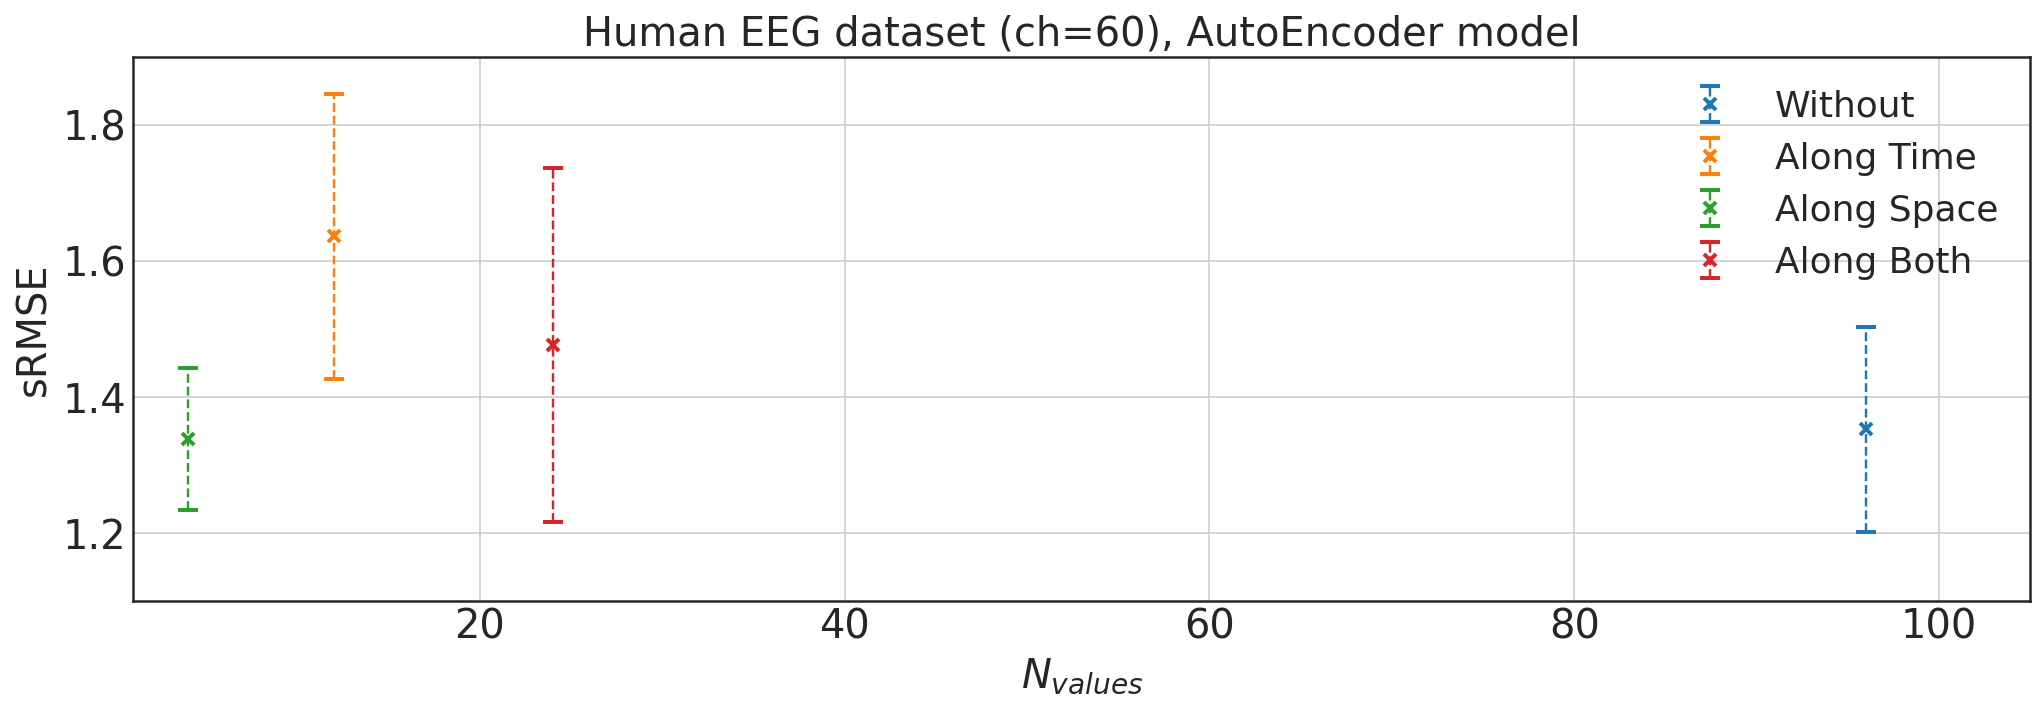

In [56]:
fig = plt.figure(figsize=(17,5))
labels = ['Without', 'Along Time', 'Along Space', 'Along Both']
xs = np.array([96, 12, 4, 24])
ys = np.array([1.352, 1.636, 1.338, 1.476])
es = np.array([0.151, 0.210, 0.105, 0.260])

for x, y, e, c in zip(xs,ys,es,range(4)):
    eb1=plt.errorbar(x, y, e, linestyle='None', marker='x', capsize=5, elinewidth=1.2, markeredgewidth=2, label=labels[c])#, ecolor=c)
    eb1[-1][0].set_linestyle('--') 
# for i,(xitem,yitem) in enumerate(np.nditer([x,y])):
#     plt.annotate(labels[i], (xitem,yitem), textcoords="offset points",xytext=((-1)**(i)*35,(-1)**(i//2)*10),ha="center")
plt.ylim(1.1,1.9)
plt.xlim(1,105)
plt.ylabel('sRMSE', fontsize=20)
plt.xlabel(r'$N_{values}$', fontsize=20)
plt.grid(True)
plt.legend()
plt.savefig('EEG60_AE.jpg', dpi=300)
plt.title('Human EEG dataset (ch=60), AutoEncoder model')
plt.show()